# Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime
from scipy.stats import norm
from statsmodels.tsa.arima.model import ARIMA

# Loading the Dataset

Air passenger data is downloaded to the `/data` subdirectory of the root project folder. We will use `pandas` to create a data frame with this data. 

In [2]:
data = pd.read_csv('data/AirPassengers.xls', index_col=0)
data.columns = [ 'Count' ] # Renaming `#Passengers` -> `Count` for convenience
data.head()

,Count
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


In [3]:
data.tail()

,Count
Month,
1960-08,606
1960-09,508
1960-10,461
1960-11,390
1960-12,432


We see that the dataset looks relatively simple. It contains monthly data about the number of air passengers from 1949 to 1960. Let's see more detailed description of the data using `pandas.describe()`:

In [4]:
data.describe()

,Count
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


Having taken a better look we can note down a couple observations:
 - There are 144 observations
 - The distribution is centered around 280
 - The distribution is skewed towards larger values jugding from **quartiles** and **min-max** range

Let's import libraries required for performing the analysis and forecasting outlined in the paper.

# Time Series Modelling - ARIMA

We will fit a simple **A**uto**R**egressive **I**ntegrate **M**oving **A**verage, or **ARIMA**, model to our time series of air passengers.

First, we should plot the time series and it's first difference, as is customary:

In [5]:
# First difference is computed by diffing values with shifted values. We then fill NAs with 0s to
# handle the first difference.
data[ 'Diff' ] = (data[ 'Count' ] - data[ 'Count' ].shift(1)).fillna(0)
data.head()

,Count,Diff
Month,,
1949-01,112,0.0
1949-02,118,6.0
1949-03,132,14.0
1949-04,129,-3.0
1949-05,121,-8.0


array([<Axes: xlabel='Month'>, <Axes: xlabel='Month'>], dtype=object)

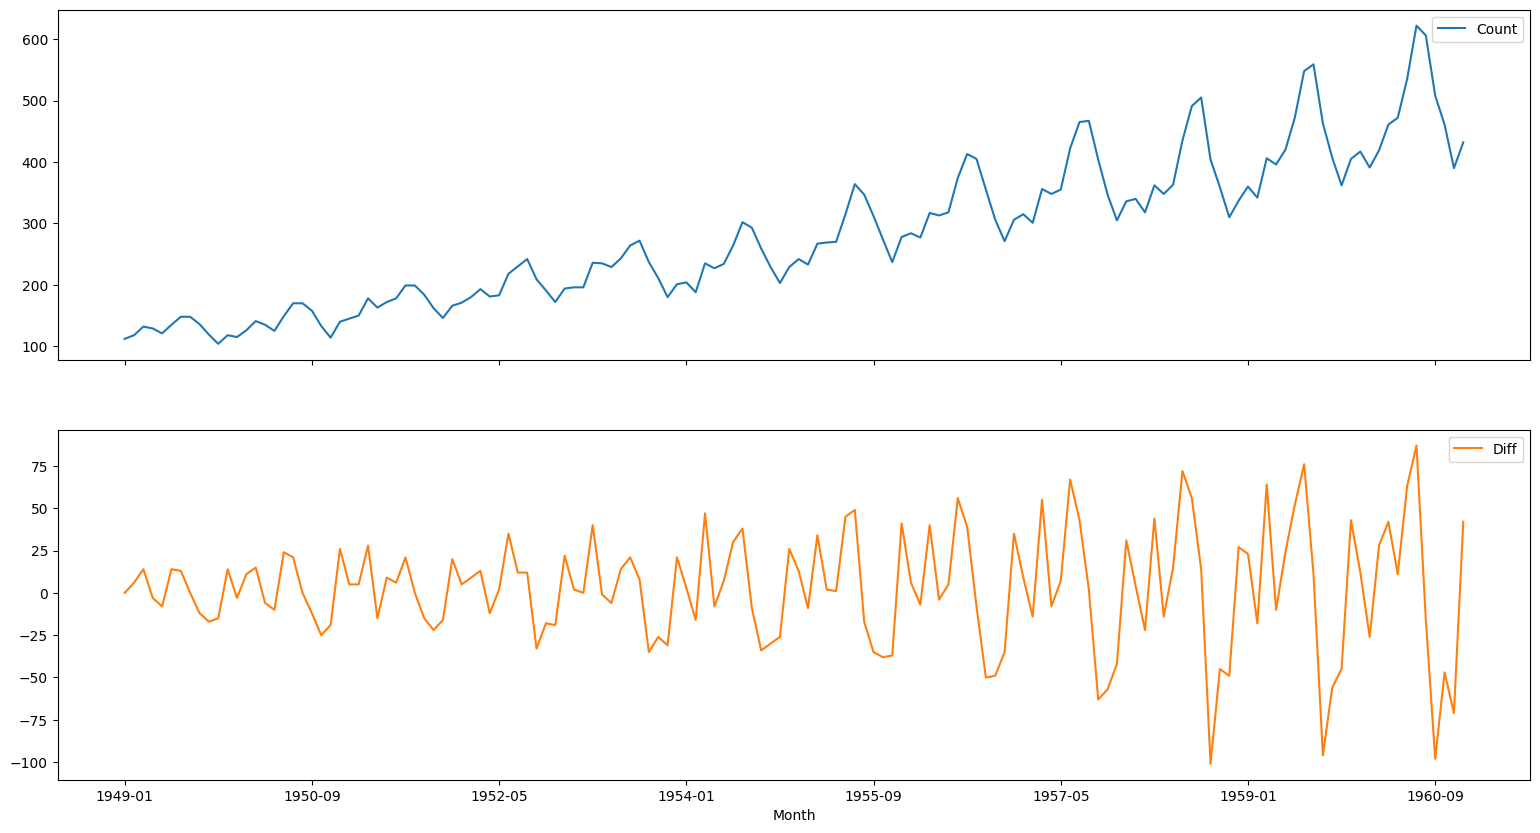

In [6]:
data.plot(figsize=(19, 10), subplots=True)

## Visual Inspection

At the first glance we see that the data does not contain missing values. It's a discrete series, because we sample our values monthly. It appears seasonal, which is in line with the meaning of the values in the data frame - they reflect the number of air passengers, so it's natural that we observe more passengers during, for example, summer.

## Train-Test Split
There is no clear mention of the approach used to split the data into training and test sets. Judging by the final forecast visualisation, 1958 appeared to be the cutoff point between training and test sets. After this point there was an additional ARIMA curve until the end of the series used to forecast air passenger volumes in comparison with the actual time series.

We will therefore set 1949-1957 as the training set and 1958-1960 as the test set.

In [7]:
data = data.reset_index()
data['Date'] = data.apply(lambda x: datetime.datetime.strptime(x['Month'], '%Y-%m'), axis = 1).dt.date
data = data.drop(['Month'], axis = 1)

In [8]:
train = data.loc[data['Date'] < datetime.date(1958, 1, 1)]
train.tail()

,Count,Diff,Date
103,467,2.0,1957-08-01
104,404,-63.0,1957-09-01
105,347,-57.0,1957-10-01
106,305,-42.0,1957-11-01
107,336,31.0,1957-12-01


In [9]:
test = data.loc[data['Date'] >= datetime.date(1958, 1, 1)]
test.head()

,Count,Diff,Date
108,340,4.0,1958-01-01
109,318,-22.0,1958-02-01
110,362,44.0,1958-03-01
111,348,-14.0,1958-04-01
112,363,15.0,1958-05-01


## Stationarity

We should check if the series is stationary. As per visual inspection we see that it should not be. We will use the <ins>**A**ugumented **D**ickey-**F**uller</ins> (**ADF**) test ([*Wikipedia* link](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test)), which is a part of the `statsmodels` library.

In [10]:
# Small helper function for performing the DF test on a time series. 
def ADF(series):
    (adf_test, adf_p) = sm.tsa.stattools.adfuller(series)[:2]
    print(f"ADF Test Statistic = {adf_test}, p-value = {adf_p}")

ADF(train[ 'Count' ])

ADF Test Statistic = 1.002586510133105, p-value = 0.9942931644042374


Because the *p-value* is outside the critical region, we **fail to reject the null** hypothesis about the stationarity of the series. This is in line with our initial expectations. We will assume that the series is non-stationary.

The authors of the paper arrive at a different test statistic.

They actually obtain the following test statistic which assumes the use of the entire time series (train + test).

In [11]:
# Small helper function for performing the DF test on a time series. 
def ADF(series):
    (adf_test, adf_p) = sm.tsa.stattools.adfuller(series)[:2]
    print(f"ADF Test Statistic = {adf_test}, p-value = {adf_p}")

ADF(data[ 'Count' ])

ADF Test Statistic = 0.8153688792060441, p-value = 0.9918802434376409


For completeness, let's also check the stationarity of the series of first differences:

In [12]:
ADF(train[ 'Diff' ])

ADF Test Statistic = -2.349322039808021, p-value = 0.15655343854659193


The p-value is still high enough for the null hypothesis not to be rejected at 10% confidence level.

In [13]:
ADF(data[ 'Diff' ])

ADF Test Statistic = -2.8891860694712648, p-value = 0.04662003920675343


Extending the test to the entire series again, we **reject the null** at the 95% confidence level, better than the 0.07 p-value reported by the authors. This indicates the first differences are stationary and the the underlying series is I(1).

The authors of the paper describe that a *logarithmic transformation* is another useful option in removing the trend and fluctuations in the series. Calculating the first difference was sufficient though.

The steps that were taken by the authors include differencing and removing seasonality. They **did not** mention how was the seasonality removed - we can only guess here and perform our own estimations. 

With the process being classified as I(1), the authors proceeded to determine the order of AR and MA models for the complete ARIMA model using partial autocorrelation functions (PACF) and autocorrelation functions (ACF), respectively.

## PACF and ACF

Running PACF and ACF on the first differences on both training and overall datasets is perfomed and depicted below. The shapes of both PACF and ACF curves follow those produced by the authors with a closer match for the training set. A similar set of lags are statistically significant, as those in the paper.

In [14]:
def autocorr(data_input, func_type, ci):
    if(func_type == 'PACF'):
        func_data = sm.tsa.stattools.pacf(data_input)
    elif(func_type == 'ACF'):
        func_data = sm.tsa.stattools.acf(data_input)
    
    t = len(data_input)
    norminv = norm.ppf(ci + (1 - ci) / 2)
    bound_upper = norminv / t**0.5
    bound_lower = - norminv / t**0.5
    curve_bound_upper = [bound_upper for i in range(0,len(func_data))]
    curve_bound_lower = [bound_lower for i in range(0,len(func_data))]
    
    plt.plot(func_data, label = func_type)
    plt.plot(curve_bound_upper, 'k--', label = 'Upper Bound')
    plt.plot(curve_bound_lower, 'k--', label = 'Lower Bound')
    plt.title(func_type)
    plt.show()

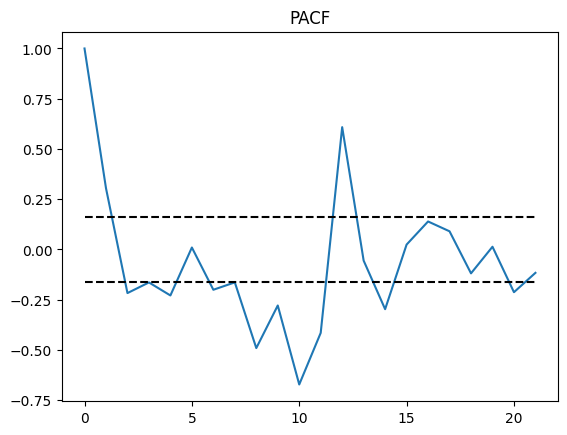

In [15]:
autocorr(data[ 'Diff' ], 'PACF', 0.95)

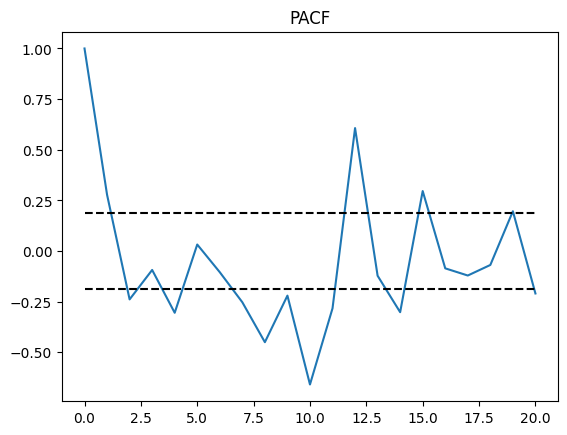

In [16]:
autocorr(train[ 'Diff' ], 'PACF', 0.95)

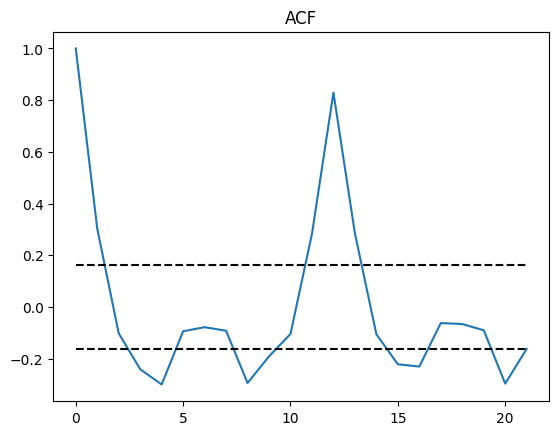

In [17]:
autocorr(data[ 'Diff' ], 'ACF', 0.95)

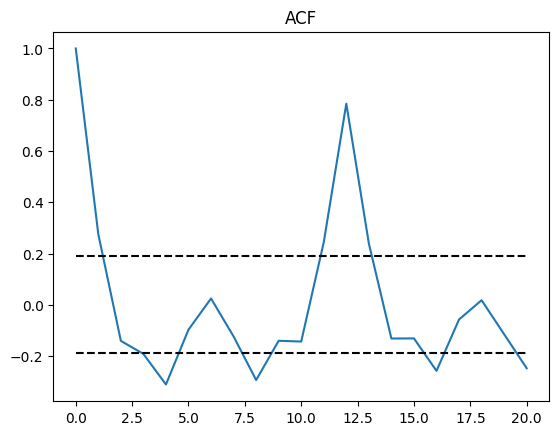

In [18]:
autocorr(train[ 'Diff' ], 'ACF', 0.95)

There is some tendency to move towards zero over time in both PACF and ACF, indicating AR and MA processes are likely to be able to explain the underlying air passenger volume series. There are several spikes and drops outside of the 95% confidence interval bounds: using training data, PACF visibly exceeds bounds at lags 8, 10 and 12 and ACF visibly exceeds bounds at lags 4, 8 and 12. Therefore, it can be expected that the components might follow p = 8/10/12 AR and q = 4/8/12 MA processes.

The authors of the paper, however, choose lower values for p and q, ending up with an ARIMA(2,1,2) model. This is likely chosen in order to maintain explainability and is supported by:
- Maximum Likelihood Estimation results which maximise the probability of obtaining the observed data
- Favourable AIC and BIC information criteria

## ARIMA Model
With the ARIMA inputs determined, we can train the model and predict the time series between 1958-1960.

In [19]:
def arima_run(data_input, order_selection, print_output):
    arima_out = ARIMA(data_input, order=order_selection)
    arima_out_res = arima_out.fit()
    if print_output:
        print(arima_out_res.summary())
        
    arima_out_pred = arima_out_res.forecast(36)
    full = pd.concat([data_input, arima_out_pred])    
    if print_output:
        plt.plot(full)
        plt.title('ARIMA ' + str(order_selection))
        plt.show()

    return(full)

**CALCULATE AIC AND BIC INFORMATION CRITERIA HERE**

                               SARIMAX Results                                
Dep. Variable:                   Diff   No. Observations:                  108
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -492.175
Date:                Fri, 09 Jun 2023   AIC                            994.351
Time:                        17:22:37   BIC                           1007.715
Sample:                             0   HQIC                           999.768
                                - 108                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5081      0.128     -3.975      0.000      -0.759      -0.258
ar.L2          0.0939      0.100      0.939      0.348      -0.102       0.290
ma.L1         -0.0698     19.930     -0.004      0.9

C:\Users\afost\Documents\UW\Y1\S2\Reproducible Research\Repro2023\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


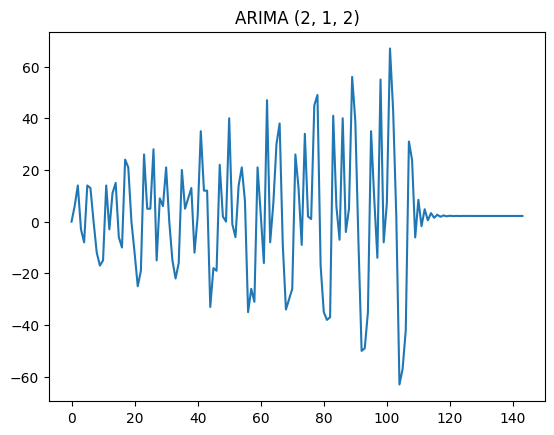

In [20]:
full212 = arima_run(train['Diff'], (2,1,2), True)

In [21]:
full210 = arima_run(train['Diff'], (2,1,0), False)

In [22]:
full012 = arima_run(train['Diff'], (0,1,2), False)

In [23]:
full212_series = []
val = data['Count'][0]

for i in full212:
    val += i
    full212_series.append(val)

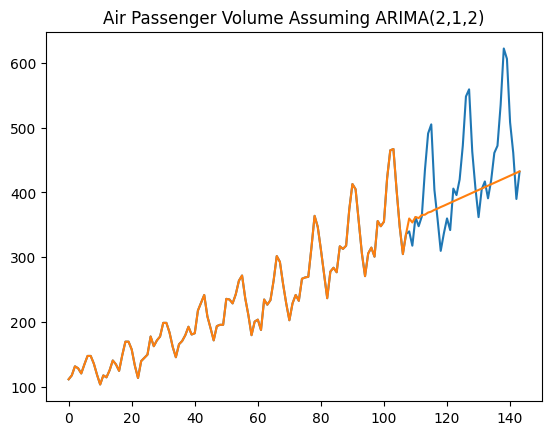

In [24]:
plt.plot(data['Count'], label = 'Observed')
plt.plot(full212_series, label = 'Predicted')
plt.title('Air Passenger Volume Assuming ARIMA(2,1,2)')
plt.show()

Each of the ARIMAs chosen by the authors produced a poor fit in this exercise. The least concerning out of the three models was ARIMA(2,1,2) but still could not reproduce the visualised prediction in the paper. Whilst it increased the series over time with the long-term trend accurately, its variability diffused too quickly and it ignored the seasonality.

**CALCULATE TRAINING ERRORS AND COMPARE VS RMS IN PAPER HERE**

In order to improve the forecast, more lags should be considered - these were significant in the PACF and ACF after all. In addition, modifying the functional form to a SARIMA model would better adapt to the data due to the seasonality in air passenger volumes. We have expanded on the paper by developing an alternative model which aims to reproduce the forecast of the authors more accurately and produce significantly better fit to the data.

## SARIMA
**INSERT SARIMA INTRO, ANALYSIS, RESULTS, PREDICTION VS ACTUAL HERE**